Task 10:-ML Facial recognition to detect mood and suggest songs              accordingly.

Name:-Wakchaure Suraj Dattatray

Dataset Link:-https://www.kaggle.com/datasets/msambare/fer2013

Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import  GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.applications.resnet50 import ResNet50

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

Image Pre-Processing

In [2]:
# the number of training examples utilized in one iteration
batch_size = 32

# set image size 224x224 for MobileNetV2
img_height = 224
img_width = 224

# path of train dataset
train_data_dir = (r"C:\Users\HOME\Desktop\train")

In [3]:
# converting pictures to numbers for modeling using keras.utils
# creating train data
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


In [4]:
# converting pictures to numbers for modeling using keras.utils
# creating validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [5]:
# classes in dataset 
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Visualize the data

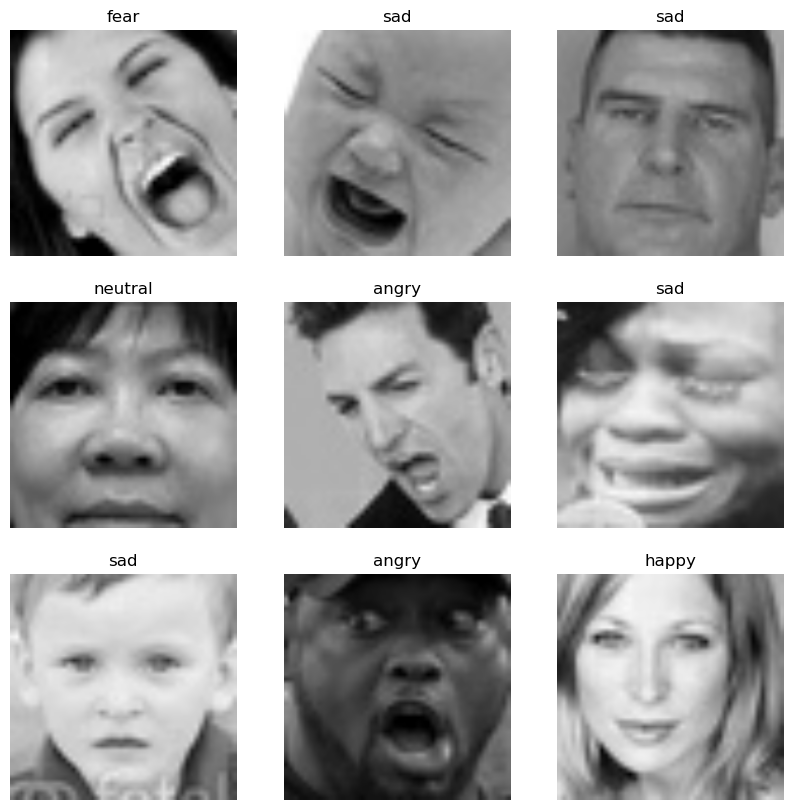

In [6]:
# plots first nine images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Model Pre-processing

1.Dataset.prefetch overlaps data preprocessing and model execution while training.
2.Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data

Standardize values to be in the [0,1] range.

In [8]:
normalization_layer = layers.Rescaling(1./255)

# apply scaling using .map
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Data Augmentation

In [9]:
# set up data augmentation function
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [10]:
# apply data augmentation to datasets
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

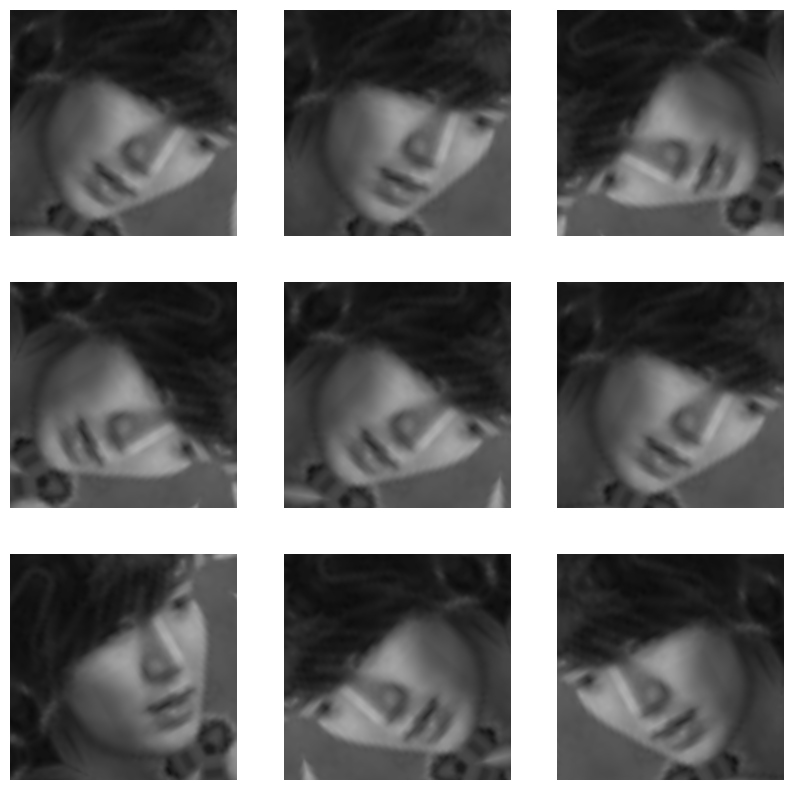

In [12]:
# visualise results of augmentation
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

Transfer Learning
Loading Pre-trained Model

In [13]:
# loading MobileNetV2 model
model = tf.keras.applications.MobileNetV2()

# freeze the convolutional base
model.trainable = False

14536120/14536120 [==============================] - 3s 0us/step


Building Model with Feature Extraction

In [14]:
# change base input
base_input = model.layers[0].input
# cut down output
base_output = model.layers[-2].output

final_output = layers.Dense(128)(base_output) 
final_output = layers.Activation("relu")(final_output) 
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation("relu")(final_output)
final_output = layers.Dense(7, activation="softmax")(final_output) # 7 classes in dataset
new_model = keras.Model(inputs = base_input, outputs = final_output)

# compile the model
new_model.compile(loss= "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [15]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

Fit the Model

In [16]:
# train the model for 5 epochs
history = new_model.fit(train_ds, epochs = 5, validation_data=val_ds)

Epoch 1/5
718/718 [==============================] - 729s 1s/step - loss: 1.5890 - accuracy: 0.3767 - val_loss: 1.4899 - val_accuracy: 0.4281
Epoch 2/5
718/718 [==============================] - 722s 1s/step - loss: 1.4921 - accuracy: 0.4239 - val_loss: 1.4825 - val_accuracy: 0.4334
Epoch 3/5
718/718 [==============================] - 725s 1s/step - loss: 1.4573 - accuracy: 0.4377 - val_loss: 1.4761 - val_accuracy: 0.4346
Epoch 4/5
718/718 [==============================] - 718s 999ms/step - loss: 1.4352 - accuracy: 0.4461 - val_loss: 1.4346 - val_accuracy: 0.4518
Epoch 5/5
718/718 [==============================] - 711s 990ms/step - loss: 1.4255 - accuracy: 0.4530 - val_loss: 1.4266 - val_accuracy: 0.4522


Training Results

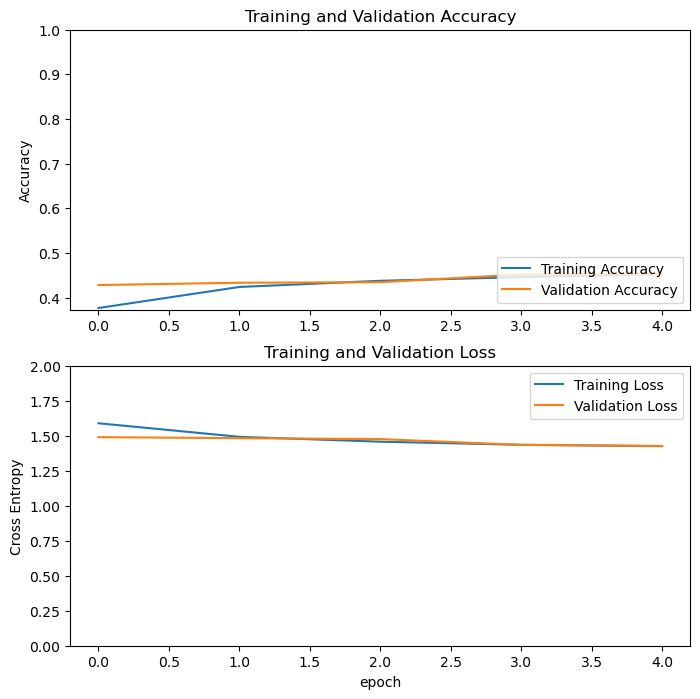

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine Tuning

Fine-tuning a pre-trained model: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. 

Unfreeze top layers of the model

In [18]:
# unfreeze top layers of the model
model.trainable = True

In [19]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  156


Compile the model

In [20]:
# compile the model using a lower learning rate to prevent overfitting
new_model.compile(loss= "sparse_categorical_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3/10),
                  metrics = ["accuracy"])

In [21]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [22]:
len(new_model.trainable_variables)

60

Continue training the model

In [23]:
total_epochs =  5

history_fine = new_model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 5/5
718/718 [==============================] - 1055s 1s/step - loss: 1.3408 - accuracy: 0.4863 - val_loss: 1.4473 - val_accuracy: 0.4480


Training Results

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

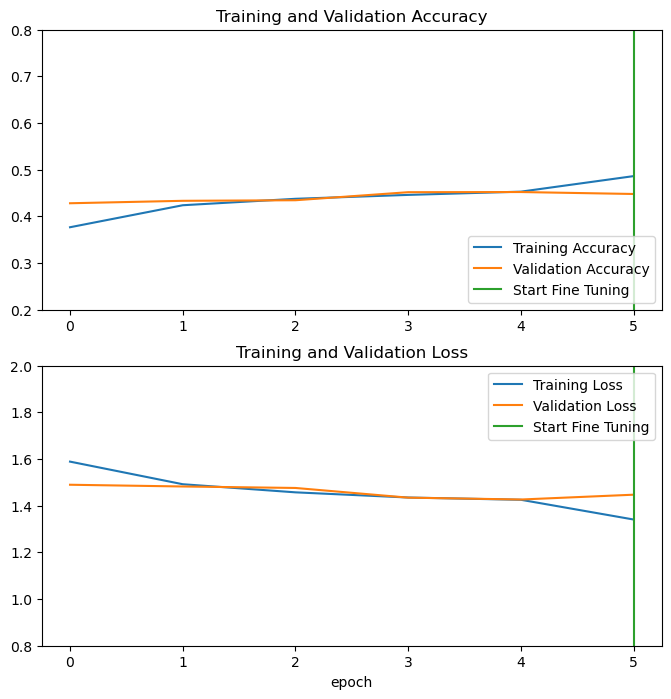

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 0.8])
plt.plot([5,5],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0.8, 2])
plt.plot([5,5],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Based on the training evaluation, we can see that after fine tuning, we started to get better results.

Model Evaluation and Prediction

Prepare test dataset

In [26]:
# converting pictures to numbers for modeling using keras.utils
# creating train data
test_data_dir = (r'C:\Users\HOME\Desktop\test')

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7178 files belonging to 7 classes.


In [27]:
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Evaluate Model with Test Dataset

In [28]:
loss, accuracy = new_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

225/225 [==============================] - 171s 756ms/step - loss: 1.4991 - accuracy: 0.4245
Test accuracy : 0.4244914948940277


Visualise Predictions

Predictions:
 [5 6 3 6 3 3 3 4 0 6 6 0 6 5 3 5 0 6 2 3 2 2 0 6 3 5 4 6 0 6 0 4]
Labels:
 [5 4 3 3 3 3 3 5 1 6 3 0 4 5 3 5 5 4 4 3 0 0 0 6 3 5 5 3 0 4 3 2]


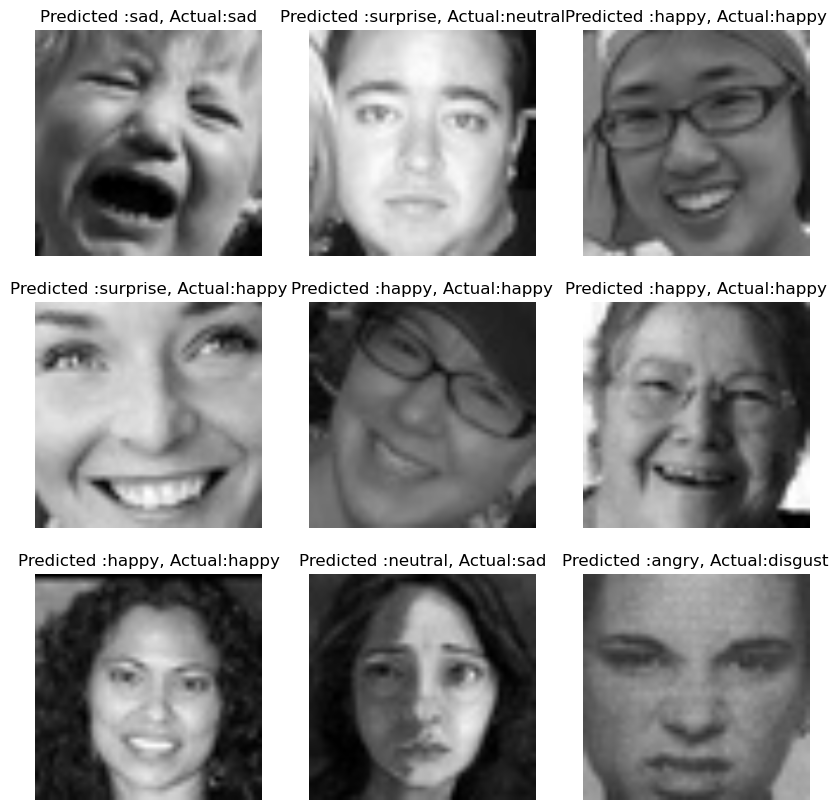

In [29]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = new_model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions =np.argmax(predictions, axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(f"Predicted :{class_names[predictions[i]]}, Actual:{class_names[label_batch[i]]}")
  plt.axis("off")

Classification Report

In [30]:
print("Classification Report: \n", classification_report(predictions, label_batch,target_names=['Angry',
                                                                                                'Disgust',
                                                                                               'Fear',
                                                                                               'Happy',
                                                                                               'Neutral',
                                                                                               'Sad',
                                                                                               'Surprise']))

Classification Report: 
               precision    recall  f1-score   support

       Angry       0.60      0.50      0.55         6
     Disgust       0.00      0.00      0.00         0
        Fear       0.00      0.00      0.00         3
       Happy       0.64      1.00      0.78         7
     Neutral       0.00      0.00      0.00         3
         Sad       0.57      1.00      0.73         4
    Surprise       1.00      0.22      0.36         9

    accuracy                           0.50        32
   macro avg       0.40      0.39      0.34        32
weighted avg       0.60      0.50      0.47        32



Save Model

In [31]:
new_model.save('transfer_learning')

INFO:tensorflow:Assets written to: transfer_learning\assets


INFO:tensorflow:Assets written to: transfer_learning\assets
